# **High-Frequency Quasi-Periodic Oscillations in the Solar Corona Observed with High-Frame-Rate Imaging During the 2023 Total Solar Eclipse**
### **Data Processing and Analysis Notebook**

**Authors**: [Yu Liang]
**Affiliation**: [Shanghai Astronomical Observatory, Chinese Academy of Sciences, Shanghai 200030, China]  
**Contact**: [yuliang@shao.ac.cn]  
**Last Updated**: [2024-12-10]  

---

### **Notebook Overview**

These Jupyter Notebook documents the processing and analysis of observational data collected during the 2023 total solar eclipse. The primary objectives of this Notebook include:

1. Preprocessing of raw white-light corona imaging data (dark field subtraction, flat field correction, and temporal registration).
2. Application of wavelet analysis to detect high-frequency quasi-periodic oscillations (HFQPOs).
3. Visualizations of the solar corona and statistical results for Sun-as-a-star analysis.

---

### **Dependencies**

The analysis relies on the following Python libraries (compatible versions):  
- `numpy==1.2.43`  
- `pandas==1.5.1`  
- `scikit-image==0.20.0`  
- `matplotlib==3.7.1`  
- `astropy==5.1.1`  
- `opencv-python==4.7.0.72`  
- `Pillow==9.2.0`  
- `scipy==1.13.1`  


<!-- A complete list of dependencies can be found in the accompanying `requirements.txt`. -->

---

### **Data Source**

- **Observation Site**: Learmonth Airport, Australia  
- **Instrument**: iPhone with 565 nm filter, sampling at 240 fps, frams width * height: 720.0 * 1280.0, image shape:(1280, 720, 3)  
- **Date**: April 20, 2023  

---

### **Main Structure**

- **Section 1**: Data loading and inspection  
- **Section 2**: Preprocessing (dark field, flat field, and registration)  
- **Section 3**: Wavelet analysis and signal detection  
- **Section 4**: Results visualization and discussion  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.io import fits
import skimage.io as io 
import struct
import imageio as iio
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
import cv2
from PIL import Image
import glob

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
path0 = '/Volumes/WD1T/share/TSE2023/'    # input dir
path1 = '/Volumes/WD1T/share/TSE2023/iPhone/result/'    # input dir
dirrb0 = path0 + 'iPhone/result/'  # results
pathfd  = path0 + 'iPhone/result/m2pic/'  # results
dirr1t = path1 + 'r1dfdatat/'  # r1dfdatat: registration 1st dark flat data totally
if not os.path.exists(dirr1t):
    os.makedirs(dirr1t)
    
dirr2t = path1 + 'r2dfdatat/'  # r1dfdatat: registration 1st dark flat data totally
if not os.path.exists(dirr2t):
    os.makedirs(dirr2t)
    
dirr2t_png = path1 + 'r2dfdatat_png/'  # r1dfdatat: registration 1st dark flat data totally
if not os.path.exists(dirr2t_png):
    os.makedirs(dirr2t_png)

In [3]:

# delete ._* files
files_to_delete = glob.glob(os.path.join(dirr2t, '._*'))

for file in files_to_delete:
    try:
        os.remove(file)
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")

In [4]:
# 5.0 data dark processing
pathd = dirr2t 
listd = os.listdir(pathd)
listd.sort()
print(listd[0:10])
print(len(listd))
st = 0
fn = len(listd) - st

['r2_r1_image_00000.fits', 'r2_r1_image_00001.fits', 'r2_r1_image_00002.fits', 'r2_r1_image_00003.fits', 'r2_r1_image_00004.fits', 'r2_r1_image_00005.fits', 'r2_r1_image_00006.fits', 'r2_r1_image_00007.fits', 'r2_r1_image_00008.fits', 'r2_r1_image_00009.fits']
13301


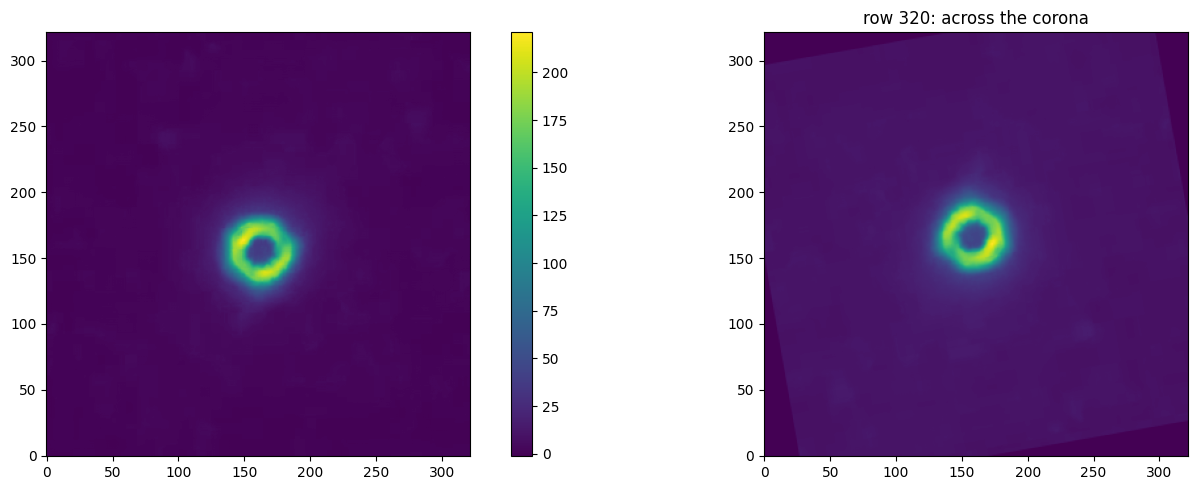

In [5]:
hdu2 = fits.open(pathd + listd[st + 6000])
img2 = hdu2[0].data

def rotimg(img2, cr, cc, degree):
    img2 = img2 + 10
    sxy = 1  # Scaling factor
    rxy = degree  # Rotation angle required for visual alignment
    m, n = img2.shape
    matrix = cv2.getRotationMatrix2D((cr, cc), rxy, sxy)
    rimg2 = cv2.warpAffine(img2, matrix, (m, n))
    rimg2 = rimg2.astype('float32')
    rimg2 -= 10
    return rimg2
import math
m,n = img2.shape
cr, cc = int(m/2), int(n/2)
r12img = rotimg(img2, cr, cc, 170)

plt.figure(figsize = [16,5])
plt.subplot(121)
plt.imshow(img2, origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(r12img, origin='lower')
plt.title('row 320: across the corona')
plt.tight_layout()
plt.show()

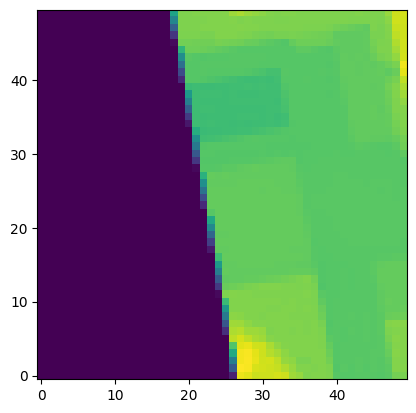

In [6]:
plt.imshow(r12img[0:50,0:50], origin='lower')

In [7]:
m,n = img2.shape
cc, cr = int(n/2), int(m/2)
ridx = 17

Text(0, 0.5, 'Coronal Height')

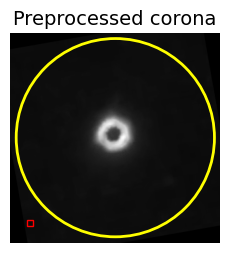

In [8]:
from matplotlib.patches import Rectangle, Circle

plt.figure(figsize = [10,6],num = 'img, rimg, pimg', dpi=100)
plt.subplot(221)
ax = plt.gca()
ax.imshow(r12img, cmap='gray', origin = 'lower')
xp, yp, width, height = 25,25,10,10

# 创建矩形并添加到坐标轴
rect = Rectangle((xp, yp), width, height, linewidth=1, edgecolor='red', facecolor='none')
ax.add_patch(rect)
# 定义圆心坐标和半径
center_x, center_y, radius = cc,cr, int(ridx/1.006*4.5 * 2)
# 创建圆并添加到坐标轴
circle = Circle((center_x, center_y), radius, linewidth=2, edgecolor='yellow', facecolor='none')
ax.add_patch(circle)
plt.axis('off')
plt.title('Preprocessed corona', fontsize=14)
plt.xlabel('Position Angle  / $\circ$', fontsize=14)
plt.ylabel('Coronal Height', fontsize=14)

In [9]:
bkgv = np.zeros([fn])
for i in range(fn):
    hdu = fits.open(pathd + listd[st + i])
    print('frame', i, 'loaded.')  
    img = hdu[0].data
    bkgimg = img[xp:xp+width,yp:yp+height]
    bkgv[i] = np.mean(bkgimg)
    
np.save('./output/bkgv.npy',bkgv)

frame 0 loaded.
frame 1 loaded.
frame 2 loaded.
frame 3 loaded.
frame 4 loaded.
frame 5 loaded.
frame 6 loaded.
frame 7 loaded.
frame 8 loaded.
frame 9 loaded.
frame 10 loaded.
frame 11 loaded.
frame 12 loaded.
frame 13 loaded.
frame 14 loaded.
frame 15 loaded.
frame 16 loaded.
frame 17 loaded.
frame 18 loaded.
frame 19 loaded.
frame 20 loaded.
frame 21 loaded.
frame 22 loaded.
frame 23 loaded.
frame 24 loaded.
frame 25 loaded.
frame 26 loaded.
frame 27 loaded.
frame 28 loaded.
frame 29 loaded.
frame 30 loaded.
frame 31 loaded.
frame 32 loaded.
frame 33 loaded.
frame 34 loaded.
frame 35 loaded.
frame 36 loaded.
frame 37 loaded.
frame 38 loaded.
frame 39 loaded.
frame 40 loaded.
frame 41 loaded.
frame 42 loaded.
frame 43 loaded.
frame 44 loaded.
frame 45 loaded.
frame 46 loaded.
frame 47 loaded.
frame 48 loaded.
frame 49 loaded.
frame 50 loaded.
frame 51 loaded.
frame 52 loaded.
frame 53 loaded.
frame 54 loaded.
frame 55 loaded.
frame 56 loaded.
frame 57 loaded.
frame 58 loaded.
frame 5

In [10]:
bkgv = np.load('./output/bkgv.npy')

In [11]:
!pwd

/Users/liangyu/Library/CloudStorage/OneDrive-USTC/codes/gitcode/github/eclipse2023


In [12]:
bkgv.shape

(13301,)

In [13]:
sno, eno = 240, 12720
ts = (eno - sno) / 240

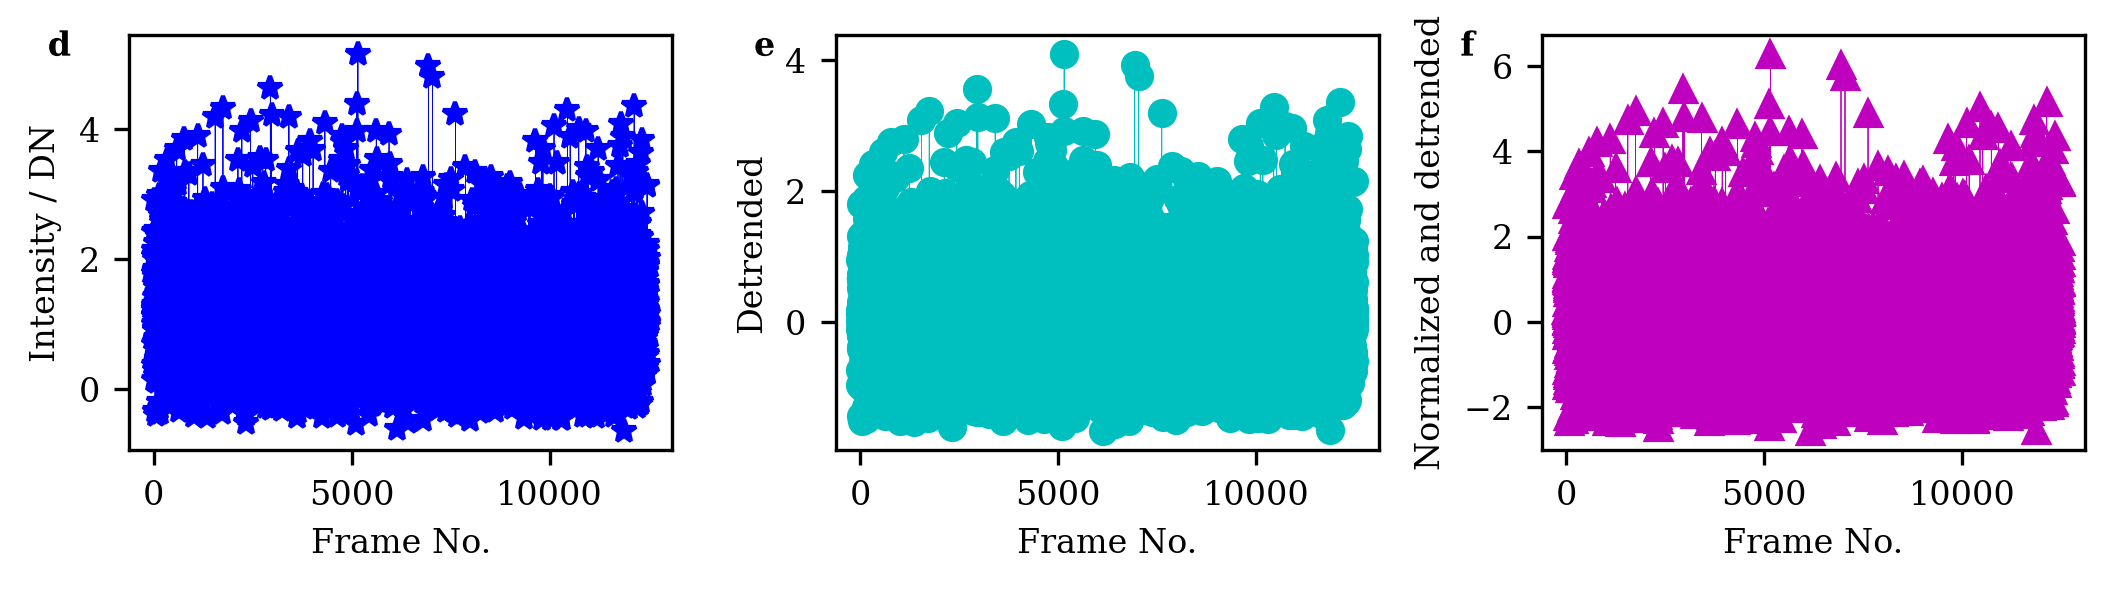

In [14]:
from __future__ import division
import numpy
from matplotlib import pyplot

import pycwt as wavelet
from pycwt.helpers import find

ctf = eno - sno# 12000 # ctf: cut frame
dt = (ts)/(ctf-1) # In seconds
dat = bkgv[sno:eno]
#dat = dat / np.abs(np.max(dat))

title = 'Intensity of Ridx_Rlim1'
label = 'Ridx_Rlim1'
units = 'counts'
t0 = 0

# We also create a time array in years.
N = dat.size
t = np.arange(0, N) * dt + t0

#mother = wavelet.DOG(6)
mother = wavelet.Morlet()
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
#J = 7 / dj  # Seven powers of two with dj sub-octaves
J = (np.log2(N * dt / s0)) / dj
#alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
#alpha, _, _ = 0,0,0
alpha = 0

# We write the following code to detrend and normalize the input data by its
# standard deviation. Sometimes detrending is not necessary and simply
# removing the mean value is good enough. However, if your dataset has a well
# defined trend, such as the Mauna Loa CO\ :sub:`2` dataset available in the
# above mentioned website, it is strongly advised to perform detrending.
# Here, we fit a one-degree polynomial function and then subtract it from the
# original data.
p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()         # Standard deviation
var = std ** 2                  # Variance
dat_norm = dat_notrend / std    # Normalized dataset

# intensity normaolized during the sample time series.
# Plotting the intensity over the sample time series


import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Update plotting parameters
plt.rcParams.update({
    'font.size': 8,
    'axes.labelsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'font.family': 'serif',
    'mathtext.fontset': 'stix',
})

# Subplot label font size
ss = 8

# Plot setup
plt.figure(figsize=[7.09, 2], dpi=300)

# Subplot 1: Original intensity
ax1 = plt.subplot(131)
ax1.plot(dat, 'b-*', linewidth=0.2)  # Adjusted line width
ax1.set_xlabel('Frame No.')
ax1.set_ylabel('Intensity / DN')
ax1.text(-0.15, 0.95, 'd', transform=ax1.transAxes, fontsize=ss, fontweight='bold',
         color='black', path_effects=[path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])

# Subplot 2: Detrended intensity
ax2 = plt.subplot(132)
ax2.plot(dat_notrend, 'c-o', linewidth=0.2)  # Adjusted line width
ax2.set_xlabel('Frame No.')
ax2.set_ylabel('Detrended')
ax2.text(-0.15, 0.95, 'e', transform=ax2.transAxes, fontsize=ss, fontweight='bold',
         color='black', path_effects=[path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])

# Subplot 3: Normalized and detrended intensity
ax3 = plt.subplot(133)
ax3.plot(dat_norm, 'm-^', linewidth=0.2)  # Adjusted line width
ax3.set_xlabel('Frame No.')
ax3.set_ylabel('Normalized and detrended')
ax3.text(-0.15, 0.95, 'f', transform=ax3.transAxes, fontsize=ss, fontweight='bold',
         color='black', path_effects=[path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])

# Adjust layout
plt.tight_layout()

pathfigs = './output/'
plt.savefig(pathfigs + 'intensity_bkg.png', bbox_inches='tight')
plt.show()


/var/folders/j1/t8_gk27x5wq61xjjlpw5qqcw0000gn/T/ipykernel_11240/2629984569.py:60: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


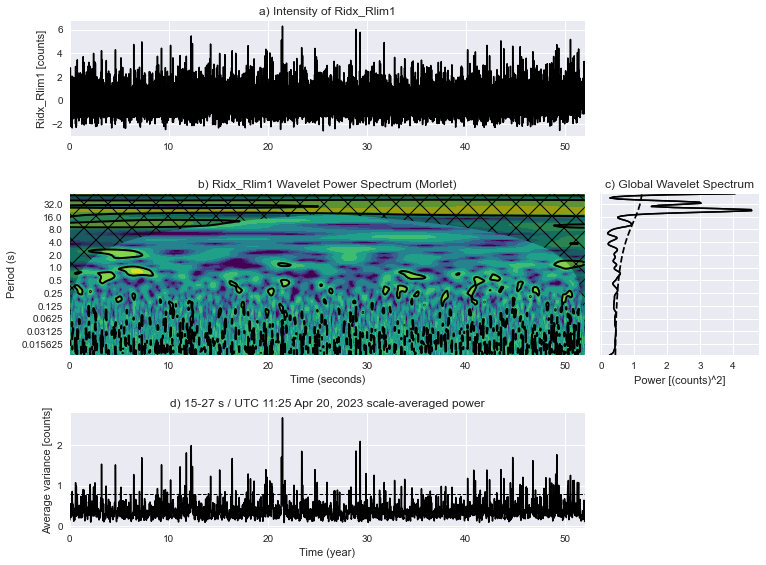

In [15]:
# https://qastack.cn/stats/134104/why-do-we-divide-by-the-standard-deviation-and-not-some-other-standardizing-fact
# wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
#                                                       mother)
# iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std   

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std   

# We calculate the normalized wavelet and Fourier power spectra, as well as
# the Fourier equivalent periods for each wavelet scale.
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

# We could stop at this point and plot our results. However we are also
# interested in the power spectra significance test. The power is significant
# where the ratio ``power / sig95 > 1``.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Then, we calculate the global wavelet spectrum and determine its
# significance level.
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

# We also calculate the scale average between 2 years and 8 years, and its
# significance level.
sel = find((period >= s0) & (period < 6))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

# Finally, we plot our results in four different subplots containing the
# (i) original series anomaly and the inverse wavelet transform; (ii) the
# wavelet power spectrum (iii) the global wavelet and Fourier spectra ; and
# (iv) the range averaged wavelet spectrum. In all sub-plots the significance
# levels are either included as dotted lines or as filled contour lines.

# Prepare the figure
pyplot.close('all')
pyplot.ioff()

import pywt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn')

figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
#ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat_norm, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))
#plt.ylim(140,148)

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_xlabel('Time (seconds)')
bx.set_ylabel('Period (s)')
#fig.colorbar(im, cax=cbar_ax, orientation="vertical")
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
# 绘制数据
cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '-.', color='#cccccc')
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
#cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        #linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
# cx.set_xlim([0, glbl_power.max() *0.0005])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}-{} s / UTC 11:25 Apr 20, 2023 scale-averaged power'.format(15 , 27))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
#plt.ylim(0,0.1)
ax.set_xlim([t.min(), t.max()])
pyplot.show()

/var/folders/j1/t8_gk27x5wq61xjjlpw5qqcw0000gn/T/ipykernel_11240/4208111815.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


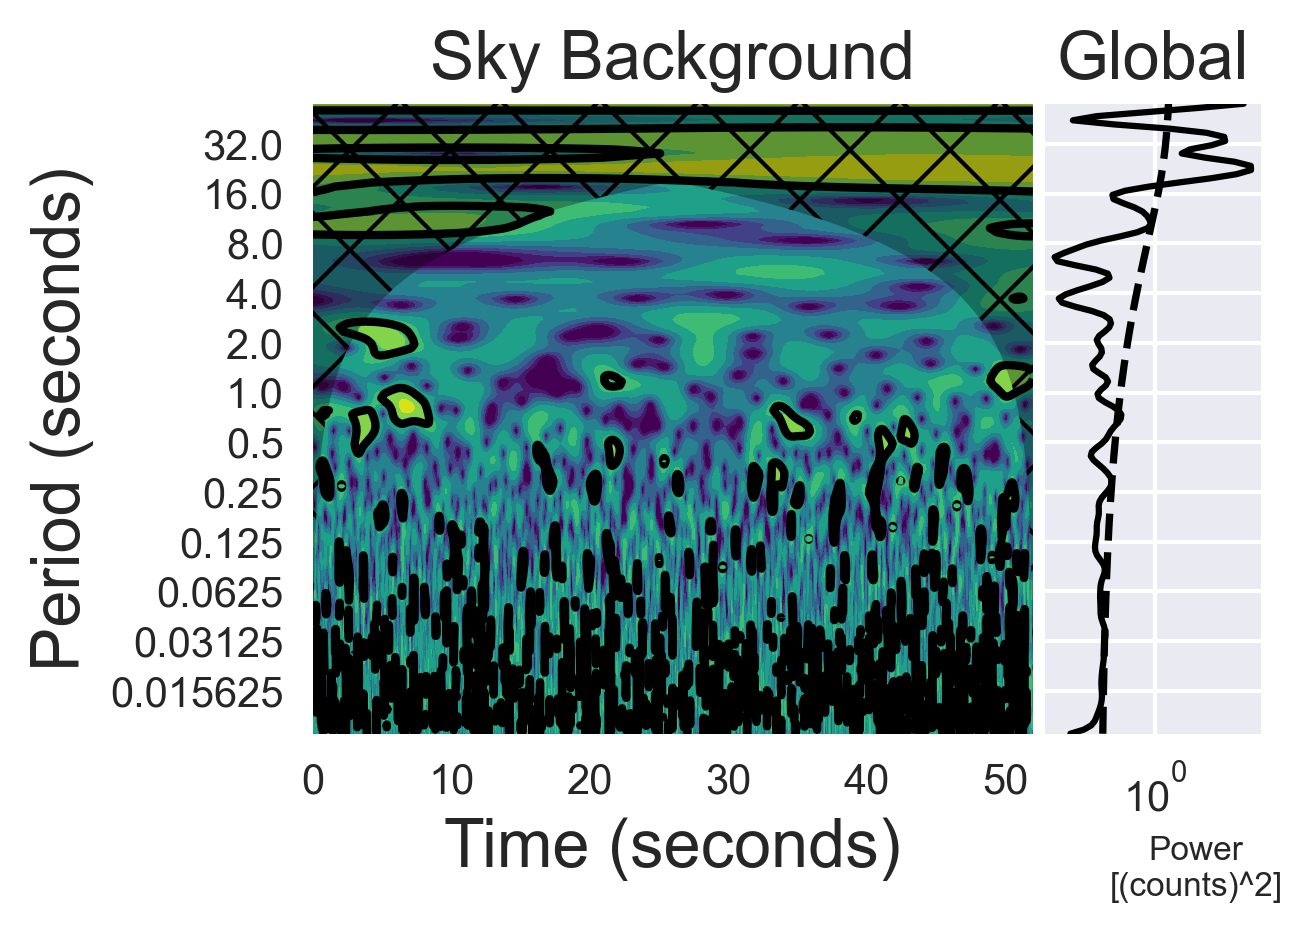

In [16]:
units = 'counts'
figprops = dict(figsize=(4,3))
fig = pyplot.figure(**figprops, dpi=300)
# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
# ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
# #ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# ax.plot(t, dat_norm, 'k', linewidth=1.5)
# ax.set_title('a) {}'.format(title))
# ax.set_ylabel(r'{} [{}]'.format(label, units))
# #plt.ylim(140,148)

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influence hatched area. Note that period
# scale is logarithmic.
#plt.axes((left, bottom, width, height), facecolor='grey')
bx = pyplot.axes([0.1, 0.18, 0.6, 0.7], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('Sky Background',fontsize = '16')
bx.set_xlabel('Time (seconds)',fontsize = '16')
bx.set_ylabel('Period (seconds)',fontsize = '16')
#fig.colorbar(im, cax=cbar_ax, orientation="vertical")
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)


# Other code

# Create Axes object cx and set shared y-axis
cx = plt.axes([0.71, 0.18, 0.18, 0.7], sharey=bx)

# Plot the data
cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '-.', color='#cccccc')
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)

# Set x-axis to logarithmic scale
cx.set_xscale('log')

# Set other properties
cx.set_title('Global', fontsize='16')
cx.set_xlabel('Power\n' + r'[({})^2]'.format(units), x=0.7, y=0.02, fontsize='8')
#cx.set_xlim([0, glbl_power.max()])
cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
plt.tight_layout()


# ss = 8
# plt.gcf().text(0.01, 0.98, 'r', fontsize=ss, fontweight='bold')

pathfigs = './output/'
plt.savefig(pathfigs + 'bkg.png', bbox_inches='tight')
pyplot.show()
pyplot.close()


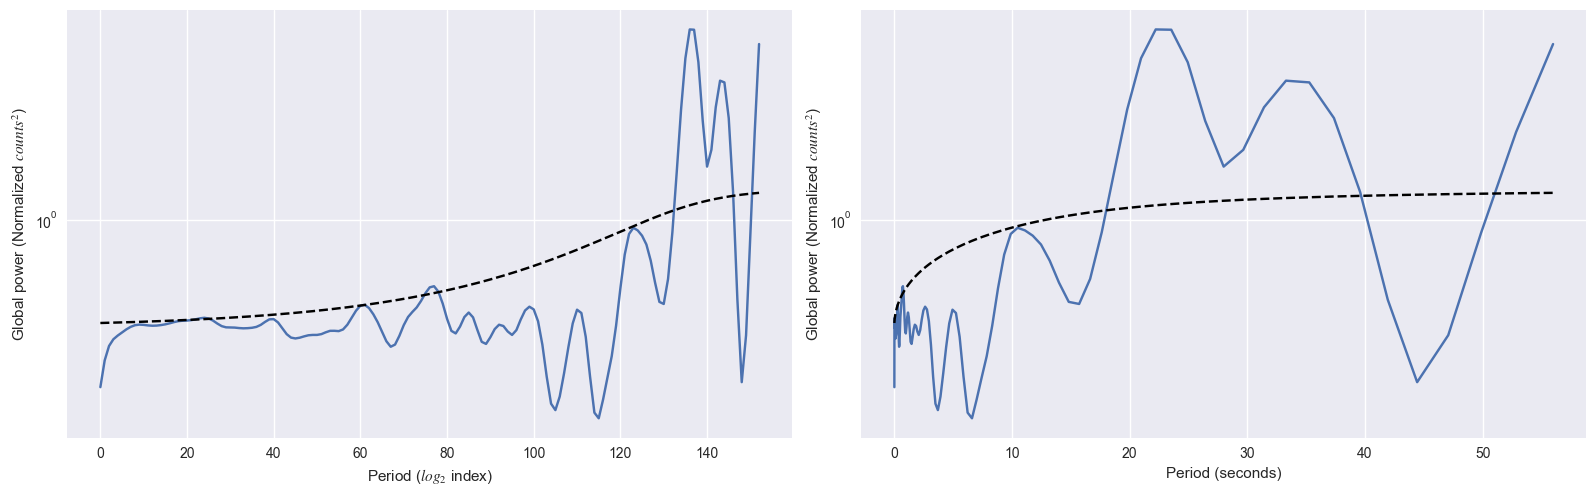

(153,) (153,) (153,)


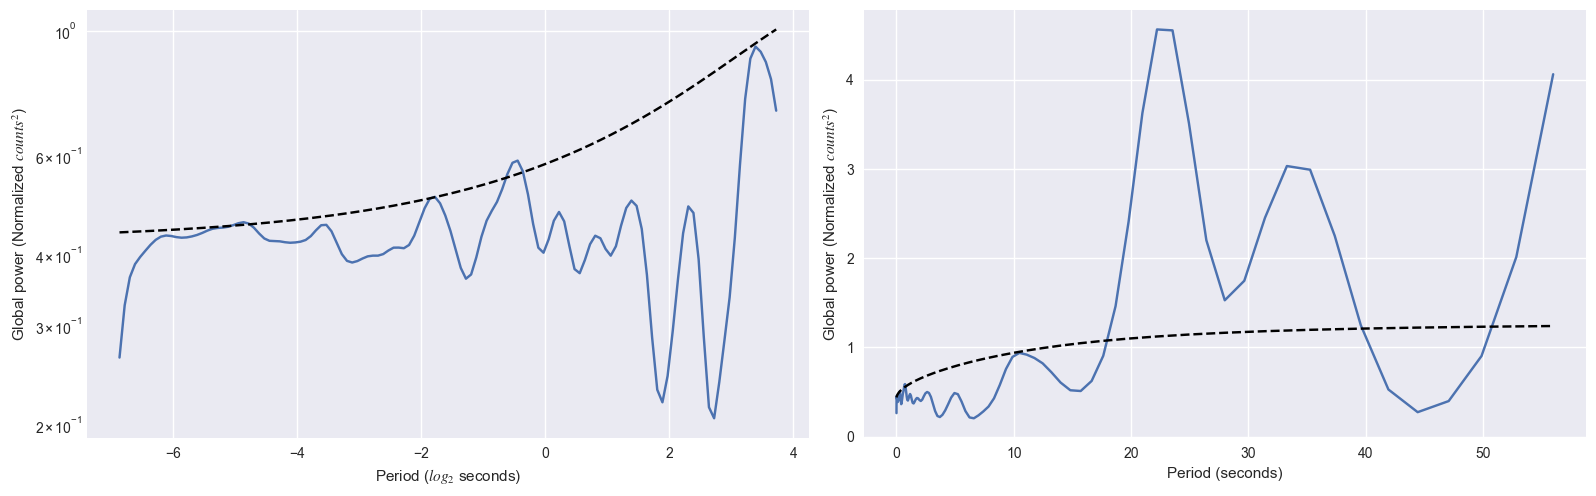

peak :  2.776869838416226 10.48406444056657 19.791278235900702 22.214958707329806
peakvalue :  0.4891876493773414 0.9382156578458875 2.409409719932721 4.564622873086978
[2.776869838416226, 10.48406444056657, 19.791278235900702, 22.214958707329806] [0.4891876493773414, 0.9382156578458875, 2.409409719932721, 4.564622873086978]


In [17]:
plt.figure(figsize=[16,5])
plt.subplot(121)
plt.plot(var * glbl_power)
plt.plot(glbl_signif, 'k--')
plt.xlabel('Period ($log_{2}$ index)')
plt.ylabel('Global power (Normalized $counts^{2}$)')
plt.yscale('log')
plt.subplot(122)
plt.plot(period, var * glbl_power)
plt.plot(period, glbl_signif, 'k--')
plt.yscale('log')
plt.xlabel('Period (seconds)')
plt.ylabel('Global power (Normalized $counts^{2}$)')
plt.tight_layout()
plt.show()

print(glbl_power.shape, glbl_signif.shape, period.shape)

plt.figure(figsize=[16,5])
plt.subplot(121)
plt.plot(np.log2(period[0:128]) ,var * glbl_power[0:128])
plt.plot(np.log2(period[0:128]), glbl_signif[0:128], 'k--')
plt.xlabel('Period ($log_{2}$ seconds)')
plt.ylabel('Global power (Normalized $counts^{2}$)')
plt.yscale('log')
plt.subplot(122)
plt.plot(period, var * glbl_power)
plt.plot(period, glbl_signif, 'k--')
plt.xlabel('Period (seconds)')
plt.ylabel('Global power (Normalized $counts^{2}$)')
plt.tight_layout()
plt.show()

scl = 1

a1,a2 = np.argmax(glbl_power[100:115]), np.argmax(glbl_power[115:125])
a1 += 100
a2 += 115
a1 = a1 * scl
a2 = a2 * scl
#     print(a0,a1,a2)
#     print(period[int(a1)],period[int(a2)])
a0 = np.argmax(glbl_power[125:135])
a0 += 125
a0 = a0 * scl
a0

#     print(period[int(a1)],period[int(a2)])
a4 = np.argmax(glbl_power[135:140])
a4 += 135
a4 = a4 * scl
a4

print('peak : ',period[int(a1)],period[int(a2)],period[int(a0)],period[int(a4)])
print('peakvalue : ',var * glbl_power[int(a1)],var * glbl_power[int(a2)],var * glbl_power[int(a0)],var * glbl_power[int(a4)])

peaks11 = [period[int(a1)],period[int(a2)],period[int(a0)],period[int(a4)]]
values11 = [var * glbl_power[int(a1)],var * glbl_power[int(a2)],var * glbl_power[int(a0)],var * glbl_power[int(a4)]]
print(peaks11, values11)
# np.save('./output/peaks' + hnm + '.npy', peaks11)
# np.save( './output/values' + hnm + '.npy', values11)
# print('./output/peaks' + hnm + '.npy' + './output/values' + hnm + '.npy' + 'saved!')

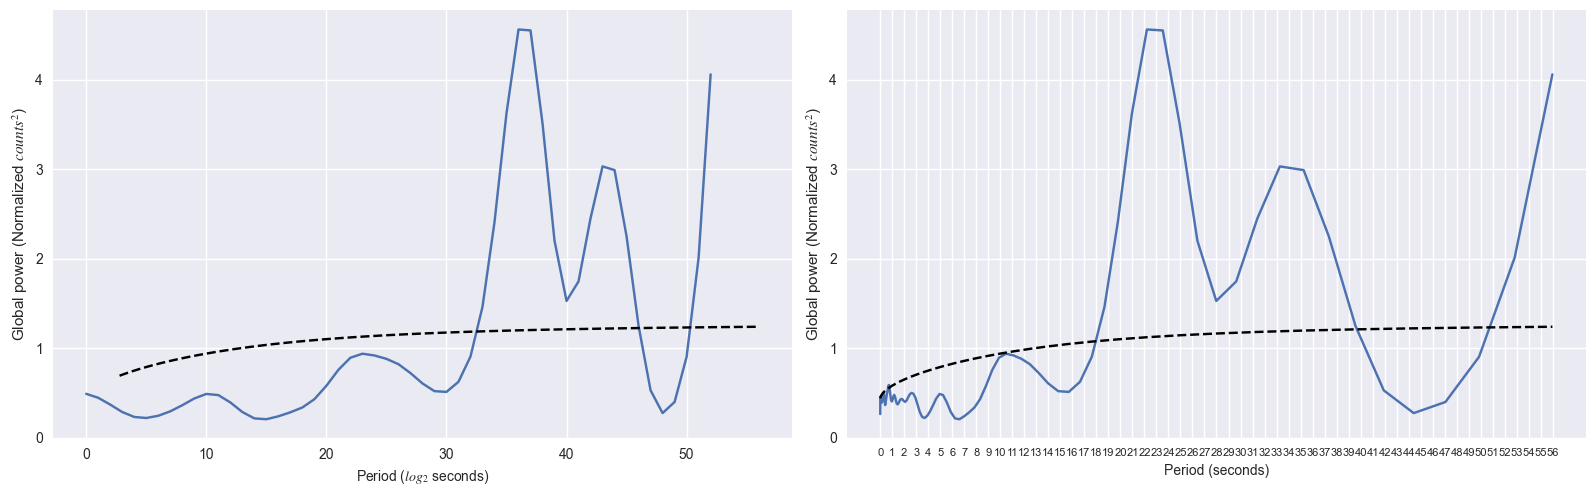

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assumed existing variables: var, glbl_power, period, glbl_signif

plt.figure(figsize=[16,5])

# Subplot 1
plt.subplot(121)
plt.plot(var * glbl_power[100::])
plt.plot(period[100::], glbl_signif[100::], 'k--')
plt.xlabel('Period ($log_{2}$ seconds)', fontsize=10)  # Set the font size of the xlabel
plt.ylabel('Global power (Normalized $counts^{2}$)')

# # Set the x-axis ticks to be every 1 unit and rotate the labels by 45 degrees
# plt.xticks(np.arange(min(period[100::]), max(period[100::])+1, 1), rotation=0, fontsize=8)  # Rotate by 45 degrees and reduce the font size

# Subplot 2
plt.subplot(122)
plt.plot(period, var * glbl_power)
plt.plot(period, glbl_signif, 'k--')
plt.xlabel('Period (seconds)', fontsize=10)  # Set the font size of the xlabel
plt.ylabel('Global power (Normalized $counts^{2}$)')

# Set the x-axis ticks to be every 1 unit and rotate the labels by 45 degrees
plt.xticks(np.arange(min(period), max(period)+1, 1), rotation=0, fontsize=8)  # Rotate by 45 degrees and reduce the font size

plt.tight_layout()
plt.show()
